In [1]:
# 多输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

上次[keras使用预训练的模型](https://www.brothereye.cn/python/429/)只是大概地使用了预训练模型，而[Keras应用  中文手册](https://keras-cn.readthedocs.io/en/latest/other/application/#application)对[Keras application](https://keras.io/applications/#vgg19)部分翻译不习惯，这次自己记录下调用函数参数的详细含义及例子。  

## 1. 预训练模型相关函数

### 1.1 导入库

In [2]:
import tensorflow
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam


%matplotlib inline
# plt.rcParamsDefault  # 查看所有默认参数
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False

### 1.2 keras.applications 查看

In [15]:
[item for item in dir(tensorflow.keras.applications) if not item.startswith('__')]

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet50',
 'VGG16',
 'VGG19',
 'Xception',
 'densenet',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'nasnet',
 'resnet50',
 'vgg16',
 'vgg19',
 'xception']

> `applications` 里存储的是一些封装的模型的模块

In [16]:
[item for item in dir(tensorflow.keras.applications.vgg19) if not item.startswith('__')]

['VGG19', 'decode_predictions', 'preprocess_input']

> 这些模块里存储的是对应的预定义好的模型，以及两个函数，`decode_predictions` 是用于将预测的结果解释成对应的标签。`decode_predictions`是对输入进行预处理：归一化

### 1.3 预定义模型的输入参数
以 VGG19 为例，默认参数为的值均为可选值的第一个，参数含义：
- `include_top`: True/False, 是否包含最后的三层(两层全连接层和一层Softmax)，用途：自己可以在模型后加自己的层来迁移学习。
- `weights`: 'imagenet'/None, 使用 imagenet 训练的权值或未训练的权值，用途：自己重新训练模型。
- `input_tensor`: None/Keras tensor, 例如使用另一层的输出（即layers.Input()）用作模型的输入，用途：自己可以在模型前加自己的层来迁移学习。
- `input_shape`: None/tuple(1x3), 在 include_top=False 时可用，输入的 shape，三维向量的元组，长宽应该大于 32，用途：在自己迁移学习上自定义输入图片的大小。
- `pooling`: None/'avg'/'max', 在include_top=False时可用，global average pooling(GAP)是否存在或avg/max方式。[GAP解释](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/), GAP就是把一层的特征整个做 pooling，每层特征输出一个值。
- `classes`: int, 在 include_top=True 且 weight=None 时可用，用途：自己重新训练模型时分类的类别总数。

关于 GAP 在此引用上面链接([GAP解释](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/))的一个图: ![global_avg_pooling](./global_average_pooling.png)

`include_top`例子：

In [3]:
model_top = VGG19(include_top=True)
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
model_notop = VGG19(include_top=False)
model_notop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

`pooling`例子

In [12]:
model_avg = VGG19(include_top=False, pooling='avg')
model_avg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

> pooling=None 见 model_notop.summary()。三个 None 中，第一个 None 是 batch_size，第二三是图片的尺寸。在global_average_pooling2d_2 ( (None, 512)中 None 是 batch_size，因为GAP将mxnx512个特征图 pooling 成 1x512、

### 1.4 预定义模型的返回
其返回是 Keras 的 Model。可以使用[tf.keras入门-训练MNIST](https://www.brothereye.cn/python/391/)中的 model的方法，如 `summary()`, `layers`等。

## 2. 可视化预训练模型
为了加深对CNN的理解，可视化中间的特征（有时写东西可以放这些图`>_<`）。方法和过程同[tf.keras入门-训练MNIST](https://www.brothereye.cn/python/391/#index-12)

In [4]:
# 可视化卷积模板
def plot_conv_weights(weights, channel=0):
    '''
    :param weights: 卷积层的权值矩阵，也就是卷积模板
    :param channel: 通道
    '''
    w_min = np.min(weights)  # 权值阵最小值
    w_max = np.max(weights)  # 权值阵最大值

    # 权值阵的第四个元素就是 filter 的数量
    num_filters = weights.shape[3]
    # 将 filter 的数量开方在向上取整，得到 n x n 的网格
    num_grids = np.ceil(np.sqrt(num_filters)).astype(np.int8)

    # Create figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # hspace上下间距，wspace左右间距

    # Plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weughts.
        if i < num_filters:
            # 因为可能 filter数量不一定能整开方。如 32，那网格就是 6x6, i大于31就没有filter了
            img = weights[:, :, channel, i]
            # 权值矩阵: [filter_height, filter_width, channels, filter_num]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest',
                      cmap='seismic'
                      )



# 可视化卷积层的输出
def plot_conv_output(values):
    '''
    :param values: 卷积层的输出
    '''
    num_filters = values.shape[3]
    num_grids = np.ceil(np.sqrt(num_filters)).astype(np.int8)

    fig, axes = plt.subplots(num_grids, num_grids)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # hspace上下间距，wspace左右间距

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            # 因为网络的输入/出是NHWC: [n_sample, height, width, channels]
            # 卷积层输出的 channels 就是卷积模板的数量 filter_num。
            # 每个 channel 都是对应卷积模板卷积的结果。如果有16个filters所以会输出16张图片

            ax.imshow(img,
                      interpolation='nearest',
                      cmap='binary'
                      )



### 2.1 可视化原图

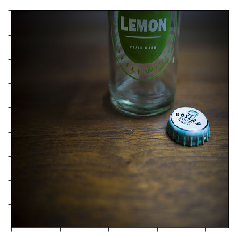

In [5]:
img_path = './bottle.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
# 输出矩阵 img，可以看到矩阵里都是 0-255 的整数，但是带有小数点，需要转化成不带小数点的 int
plt.imshow(img.astype(int));

x = np.expand_dims(img, axis=0)  # 增加一列，shape: (n, h, w, c)
x = preprocess_input(x)  # 归一化

### 2.2 获取预定义模型到 tensorboard
使用一个未训练的模型，随便输入图片训练，让其生成 tensorboard 信息。

In [ ]:
log_dir = 'e://'
y = np.int8([1])

base_model = VGG19(weights=None)

base_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(lr=1),
    metrics=['accuracy']
)

# Making training callback to save Tensorboard's log
tb_cb2 = TensorBoard(
    log_dir=log_dir,  # 设置log的存储位置
    histogram_freq=1,  # 每个 epoch 计算权值和偏置的频率
)
cbks2 = [tb_cb2]
base_model.fit(
    x, y,
    callbacks=cbks2,  # 训练时的回调函数保存 tensorboard
    validation_data=(x, y)
)


### 2.3 可视化卷积模板

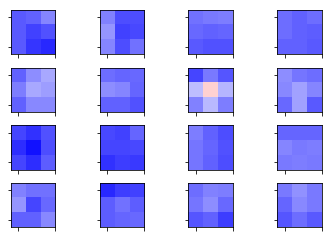

In [6]:
# get_layer(), 取出某一层，输入是层的 name。name可以用上边的 summary()查看
# 取出第三部分的第三层卷积
conv3 = model_top.get_layer('block3_conv3')
conv3_weights = conv3.get_weights()
plot_conv_weights(conv3_weights[0][:, :, :, 0:16])
# conv3_weights[0]: 权值。画出前 16 个
# conv3_weights[1]: 偏置

### 2.4 可视化各层输出

(1, 224, 224, 64)

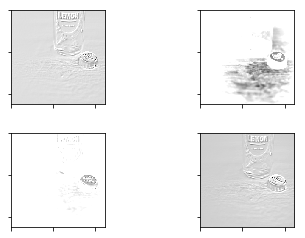

In [7]:
from tensorflow.keras.models import Model

# 输出层
layer_input = model_top.layers[0]
# 可视化第一部分第一层卷积层的输出
layer_11 = model_top.get_layer('block1_conv1')
output_11 = Model(inputs=layer_input.input,
                  outputs=layer_11.output
                    )
# 第一层卷积层 filter_num = 64, 输入一张图片会输出 64 张图片, 绘制前 4
feature_11 = output_11.predict(x)
feature_11.shape

plot_conv_output(feature_11[:, :, :, 0:4])

In [22]:
# 可视化第二部分第一层卷积层的输出
layer_21 = model_top.get_layer('block2_conv1')
output_21 = Model(inputs=layer_input.input,
                  outputs=layer_21.output
                    )
# 第一层卷积层 filter_num = 64, 输入一张图片会输出 64 张图片, 绘制前 4
feature_21 = output_21.predict(x)
feature_21.shape

(1, 112, 112, 128)

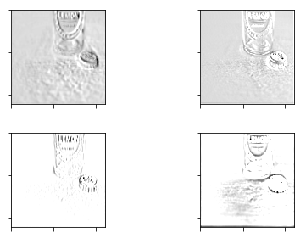

In [24]:
plot_conv_output(feature_21[:, :, :, 32:36])

In [11]:
# 可视化第三部分第一层卷积层的输出
layer_31 = model_top.get_layer('block3_conv1')
output_31 = Model(inputs=layer_input.input,
                  outputs=layer_31.output
                    )
# 绘制前 4
feature_31 = output_31.predict(x)
feature_31.shape

(1, 56, 56, 256)

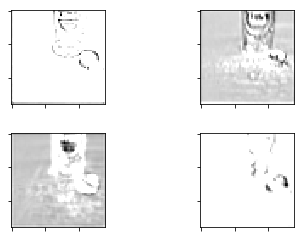

In [13]:
plot_conv_output(feature_31[:, :, :, 4:8])

In [14]:
# 可视化第四部分第四层卷积层的输出
layer_44 = model_top.get_layer('block4_conv4')
output_44 = Model(inputs=layer_input.input,
                  outputs=layer_44.output
                    )
# 绘制前 4
feature_44 = output_44.predict(x)
feature_44.shape

(1, 28, 28, 512)

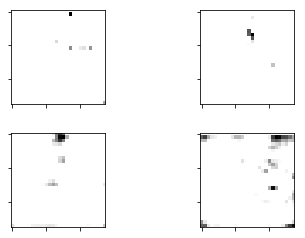

In [17]:
plot_conv_output(feature_44[:, :, :, 4:8])

In [18]:
# 可视化第五部分第四层卷积层的输出
layer_54 = model_top.get_layer('block5_conv4')
output_54 = Model(inputs=layer_input.input,
                  outputs=layer_54.output
                    )
# 绘制前 4
feature_54 = output_54.predict(x)
feature_54.shape

(1, 14, 14, 512)

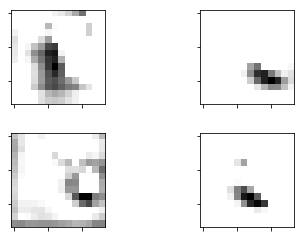

In [21]:
plot_conv_output(feature_54[:, :, :, 28:32])